# Spectral Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from sklearn.cluster import KMeans

In [2]:
data = {}
data['raw_data'] = {}
data['raw_data']['igt_orl'] = {}
data['raw_data']['igt_pvl_delta'] = {}
data['raw_data']['igt_vpp'] = {}
data['raw_data']['igt_orl']['all'] = pd.read_csv('data/parameter_igt_orl.csv')
data['raw_data']['igt_pvl_delta']['all'] = pd.read_csv('data/parameter_igt_pvl_delta.csv')
data['raw_data']['igt_vpp']['all'] = pd.read_csv('data/parameters_igt_vpp.csv')
dataset_names = ['igt_orl', 'igt_pvl_delta', 'igt_vpp']

In [3]:
#split into young and old
data['raw_data']['igt_orl']['young'] = data['raw_data']['igt_orl']['all'][data['raw_data']['igt_orl']['all']['subjID'] == 'young']
data['raw_data']['igt_orl']['old'] = data['raw_data']['igt_orl']['all'][data['raw_data']['igt_orl']['all']['subjID'] == 'old']
data['raw_data']['igt_pvl_delta']['young'] = data['raw_data']['igt_pvl_delta']['all'][data['raw_data']['igt_pvl_delta']['all']['group'] == 'young']
data['raw_data']['igt_pvl_delta']['old'] = data['raw_data']['igt_pvl_delta']['all'][data['raw_data']['igt_pvl_delta']['all']['group'] == 'old']
data['raw_data']['igt_vpp']['young'] = data['raw_data']['igt_vpp']['all'][data['raw_data']['igt_vpp']['all']['group'] == 'young']
data['raw_data']['igt_vpp']['old'] = data['raw_data']['igt_vpp']['all'][data['raw_data']['igt_vpp']['all']['group'] == 'old']

In [4]:
# these are columns which we dont want to connect
bad_cols = ['group', 'SubID', 'subjID']
age_groups = ['all', 'young', 'old']
data['processed_data'] = {}
for dataset_name in data['raw_data']:
    data['processed_data'][dataset_name] = {}
    for age_group in age_groups:
        data['processed_data'][dataset_name][age_group] = {}
        data['processed_data'][dataset_name][age_group]['by_column'] = {}
        data['processed_data'][dataset_name][age_group]['matrices'] = {}
        data['processed_data'][dataset_name][age_group]['matrices']['interval_groups'] = {}
        data['processed_data'][dataset_name][age_group]['interval_groups'] = {}
        dataset = data['raw_data'][dataset_name][age_group]
        data_points = list(dataset.columns)
        data['processed_data'][dataset_name][age_group]['column_names'] = data_points
        for col in bad_cols:
            if col in data_points:
                data_points.remove(col)
        # build interval groups
        for data_point in data_points:
            data['processed_data'][dataset_name][age_group]['by_column'][data_point] = dataset[data_point]
            interval_groups = {}
            data_column = dataset[data_point]
            # we split the range of the data in this column at 1000 equal points and split the subjects into groups
            intervals = list(np.linspace(min(data_column), max(data_column), 1001))
            i = 0
            while i < len(intervals)-1:
                mini = intervals[i]
                maxi = intervals[i+1]
                interval_groups[maxi] = []
                for j, val in enumerate(data_column):
                    if mini < val <= maxi:
                        interval_groups[maxi].append(j)
                if i == 0:
                    interval_groups[maxi].append(list(data_column).index(min(data_column)))
                i = i + 1
            # reassign group ids
            i = 0
            new_groups = {}
            for int_group in interval_groups:
                new_groups[i] = interval_groups[int_group]
#                 del interval_groups[int_group]
                i = i + 1
            data['processed_data'][dataset_name][age_group]['interval_groups'][data_point] = new_groups
            # next we want to build feature matrices based on these groups of subjects which fall within
            # the same interval for this column in the dataset
            # if the subjects are in the same group they get a relationship. simple
            matrix = np.zeros((153,153), dtype=float)
            for int_group in new_groups:
                connected_subjects = new_groups[int_group]
                for cs1 in connected_subjects:
                    for cs2 in connected_subjects:
                        if cs1 != cs2:
                            if matrix[cs1, cs2] == 0:
                                matrix[cs1, cs2] = 1
            #test the matrix to ensure it has been built correctly
            assert(matrix[0,1] == matrix[1,0])
            assert(matrix[-2,-1] == matrix[-1,-2])
            data['processed_data'][dataset_name][age_group]['matrices']['interval_groups'][data_point] = matrix

In [5]:
for dataset_name in data['raw_data']:
    master_matrix = np.zeros((153,153), dtype=float)
    for age_group in age_groups:
        for data_point in data['processed_data'][dataset_name][age_group]['column_names']:
            master_matrix = master_matrix + data['processed_data'][dataset_name][age_group]['matrices']['interval_groups'][data_point]
            data['processed_data'][dataset_name][age_group]['matrices']['interval_groups']['master'] = master_matrix

In [6]:
for dataset_name in data['raw_data']:
    data['processed_data'][dataset_name]['all']['labels'] = {}
    labels = []
    if 'group' in data['raw_data'][dataset_name]['all']:
        group_labels = data['raw_data'][dataset_name]['all']['group']
    elif 'subjID' in data['raw_data'][dataset_name]['all']:
        group_labels = data['raw_data'][dataset_name]['all']['subjID']
    for label in group_labels:
        if label == 'young':
            labels.append(0)
        if label == 'old':
            labels.append(1)
    data['processed_data'][dataset_name]['all']['labels'] = labels

Connected Graph for all in igt_orl
--------------------


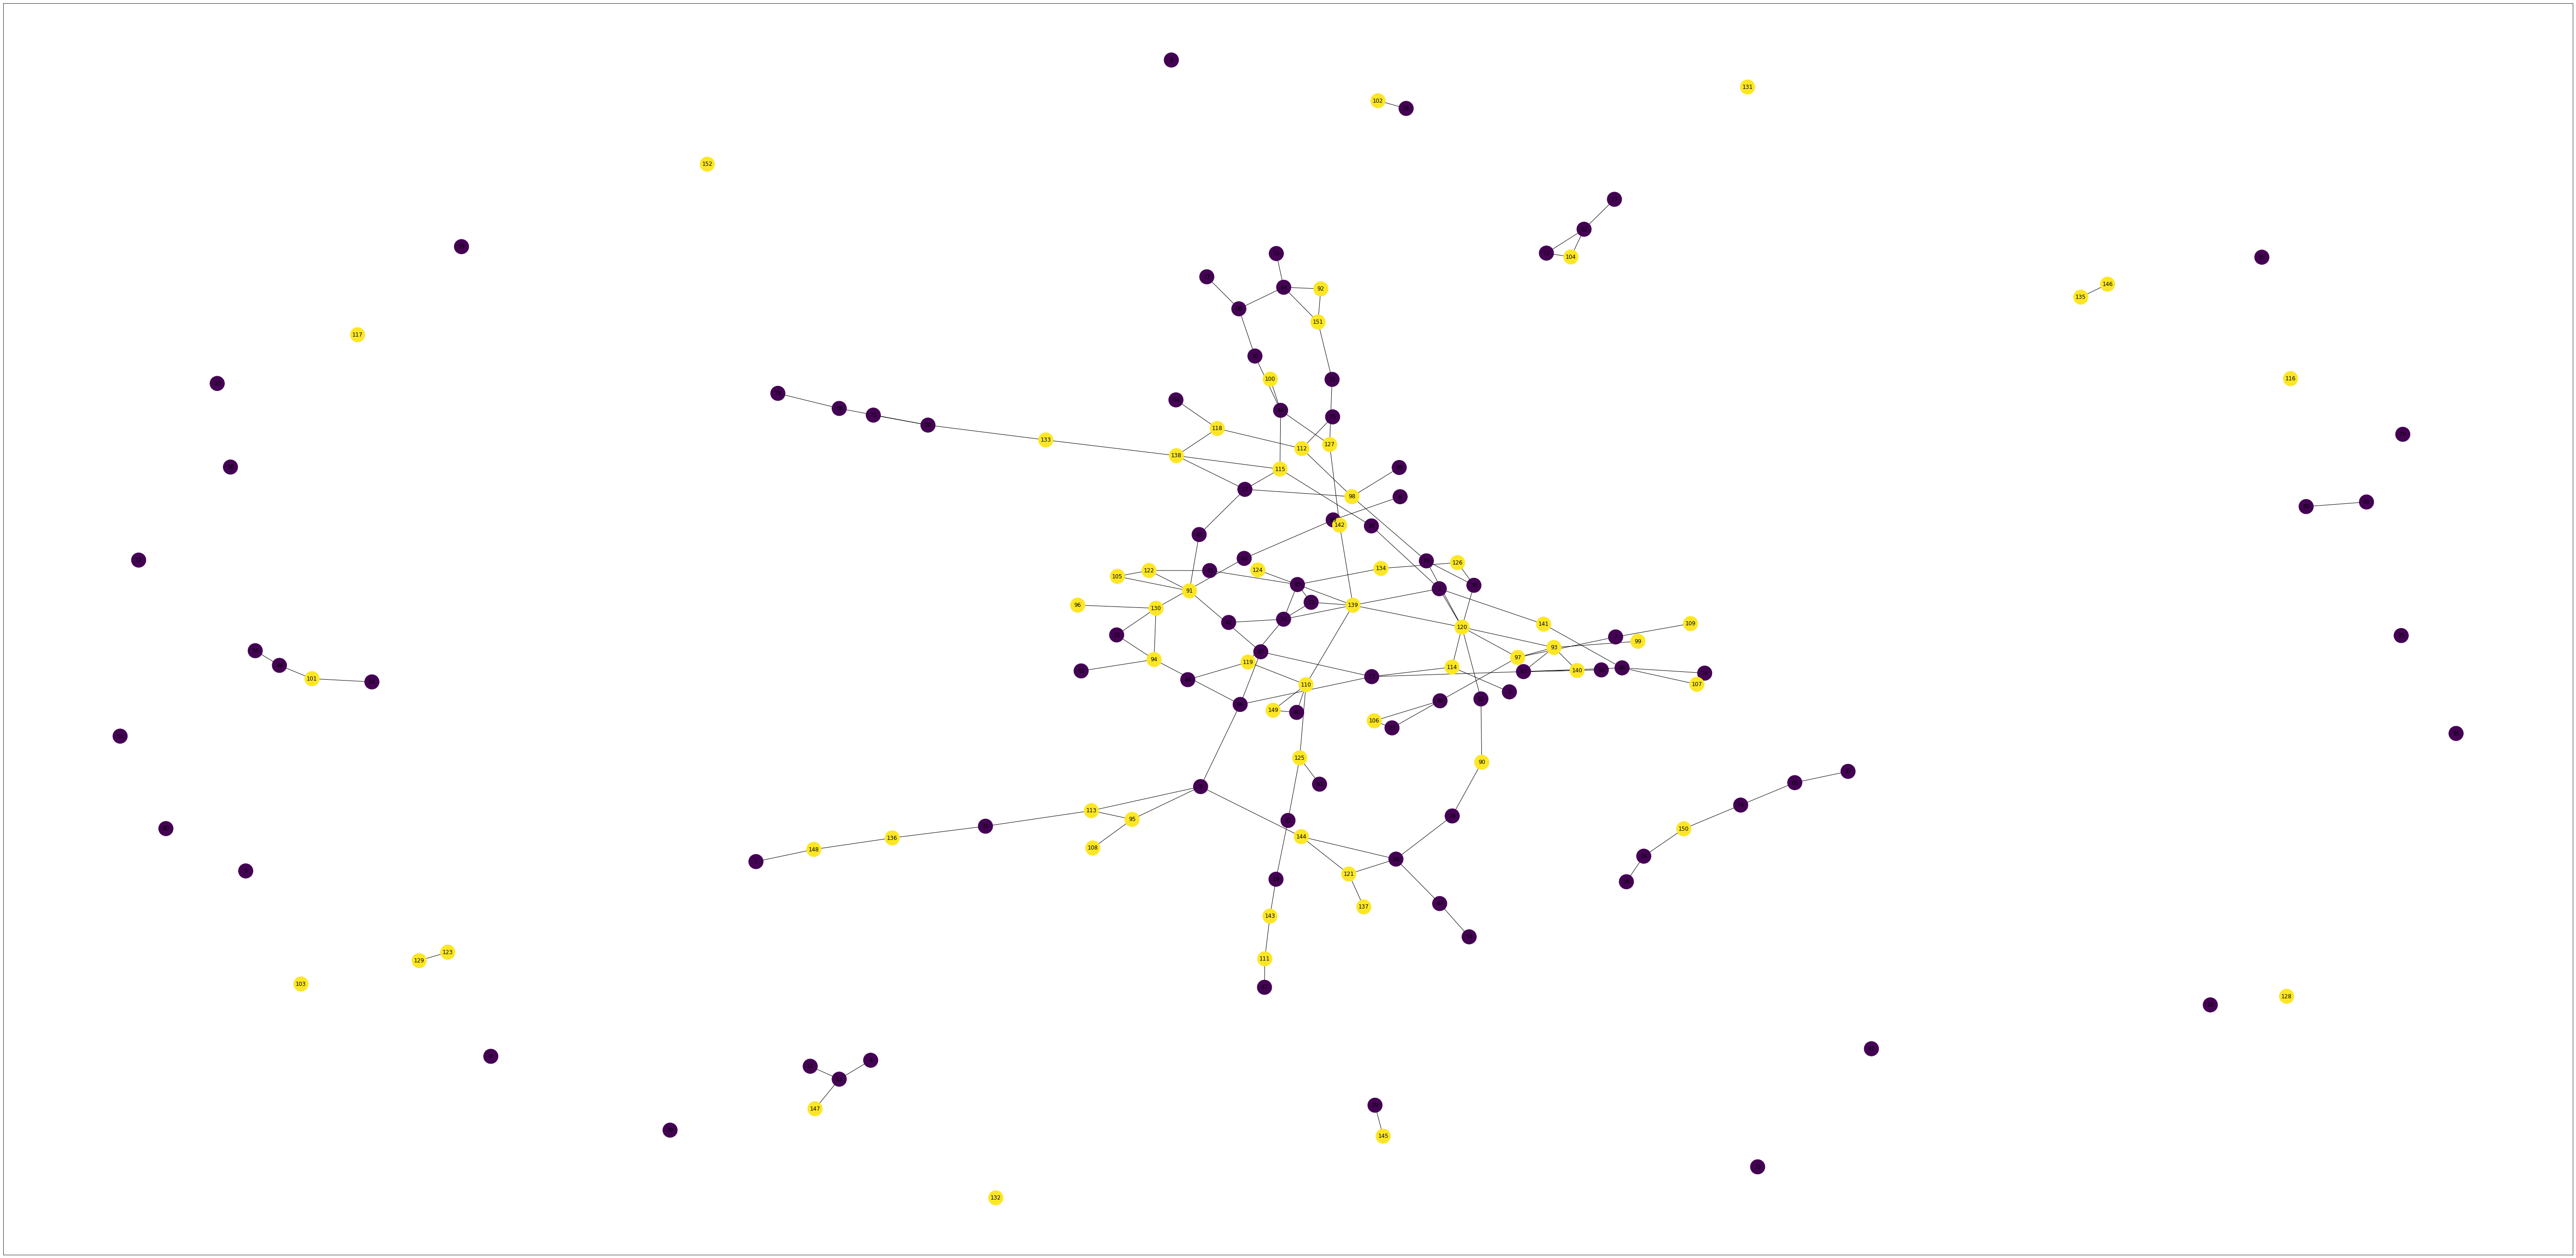

Connected Graph for young in igt_orl
--------------------


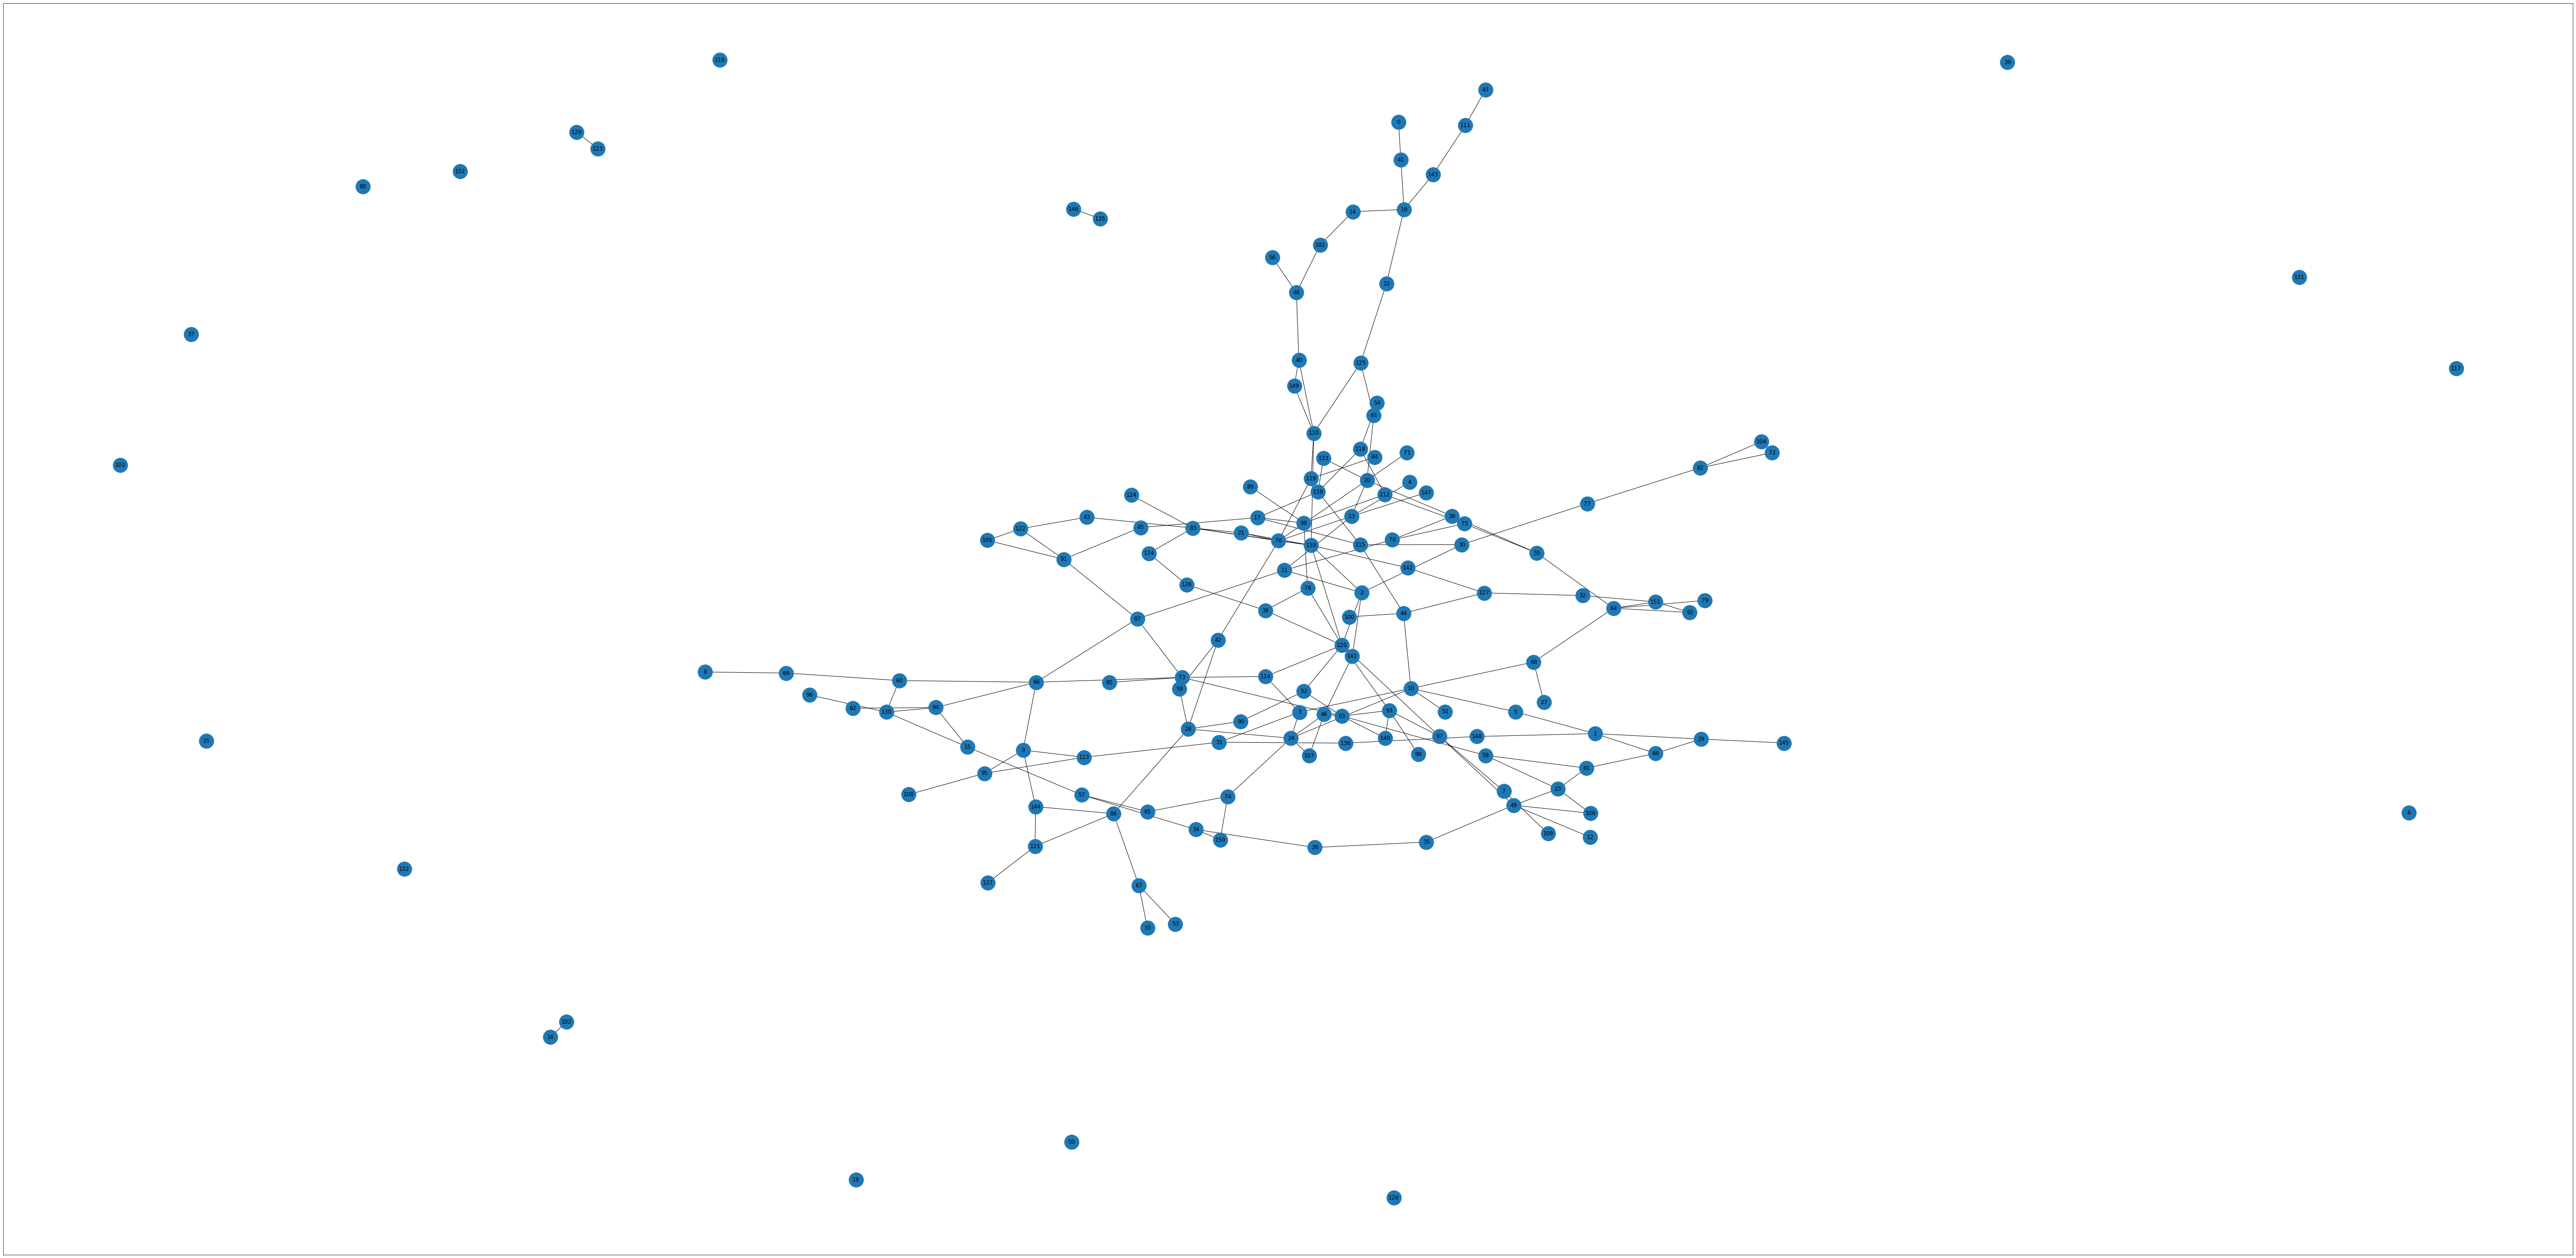

Connected Graph for old in igt_orl
--------------------


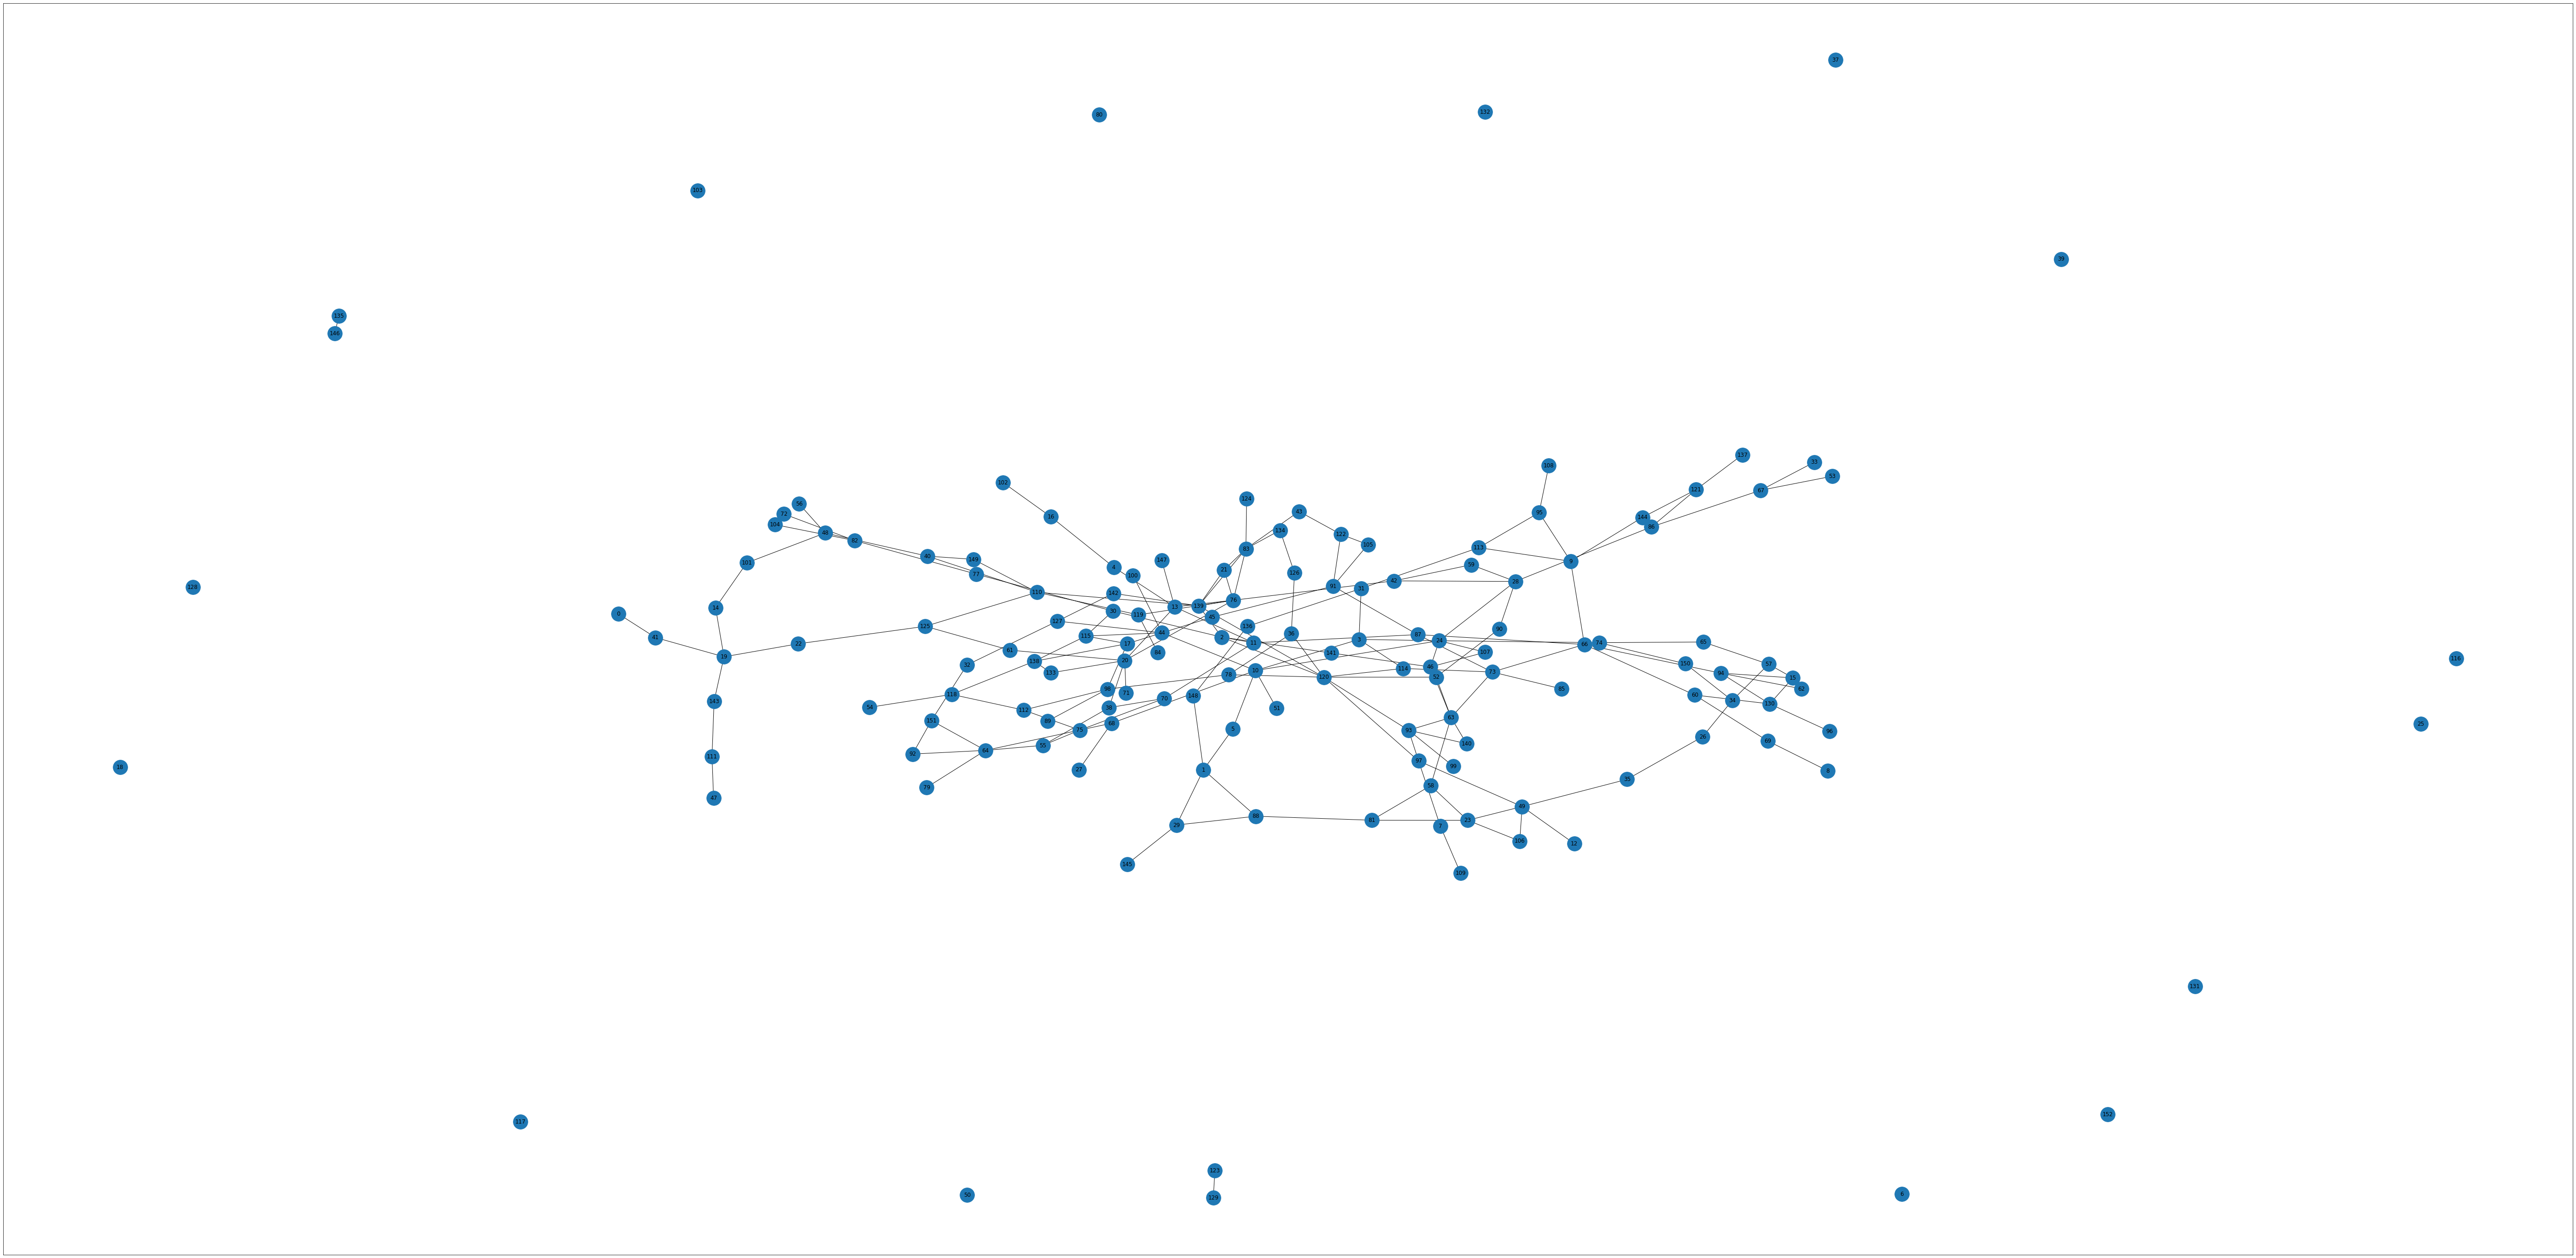

Connected Graph for all in igt_pvl_delta
--------------------


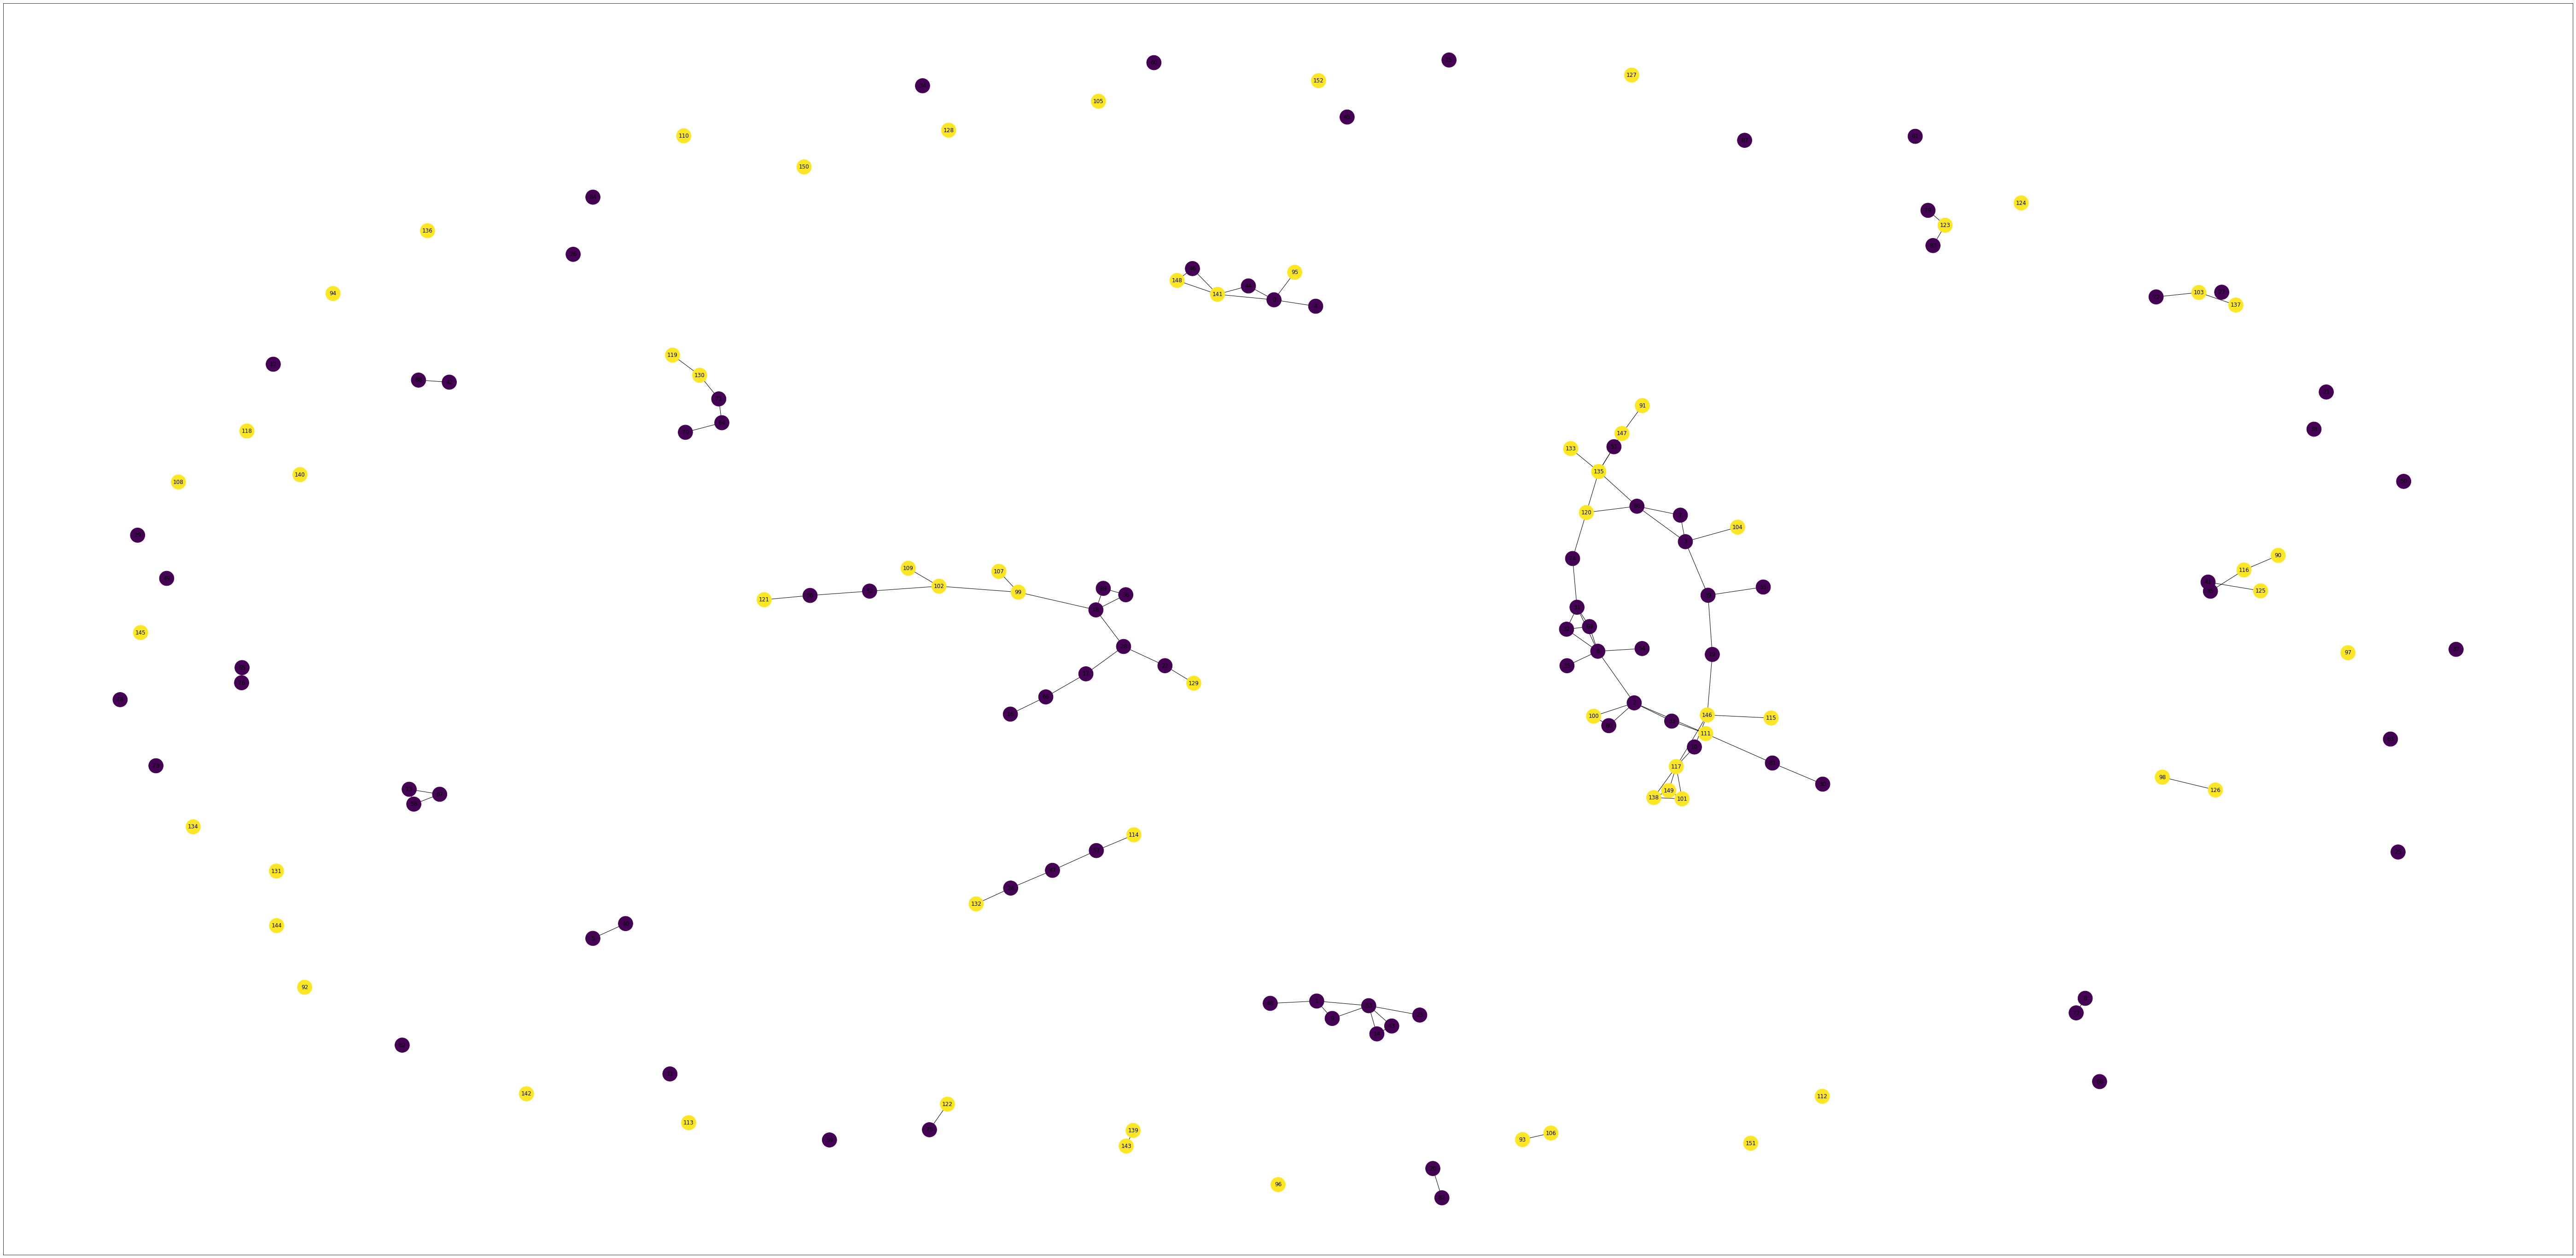

Connected Graph for young in igt_pvl_delta
--------------------


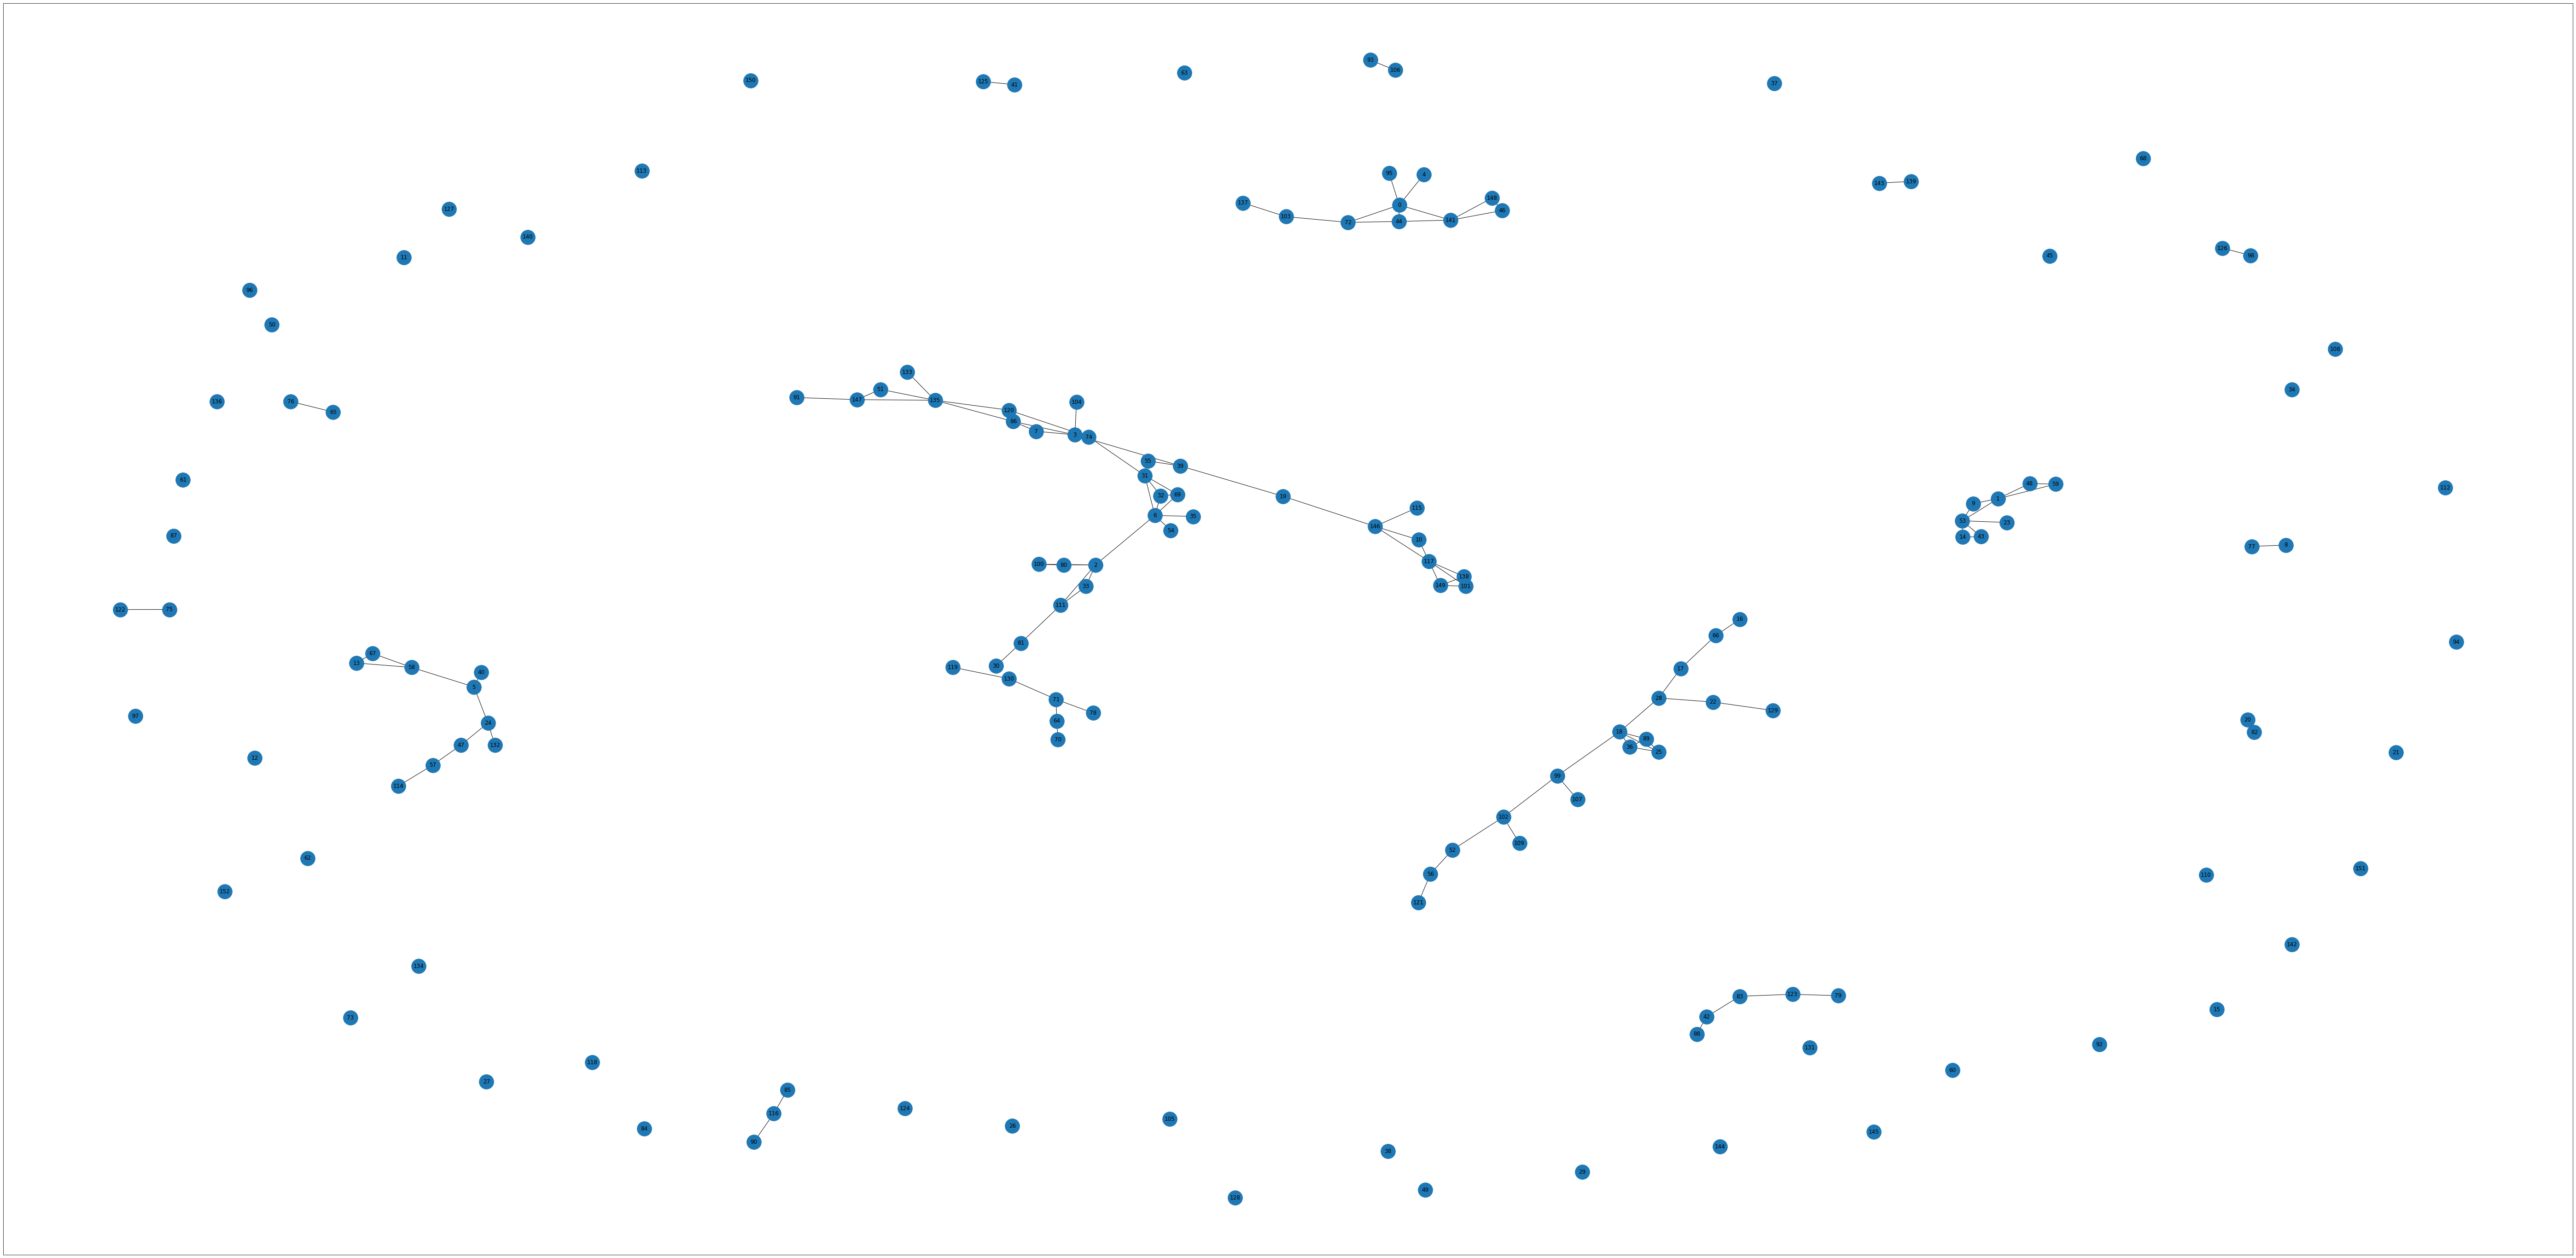

Connected Graph for old in igt_pvl_delta
--------------------


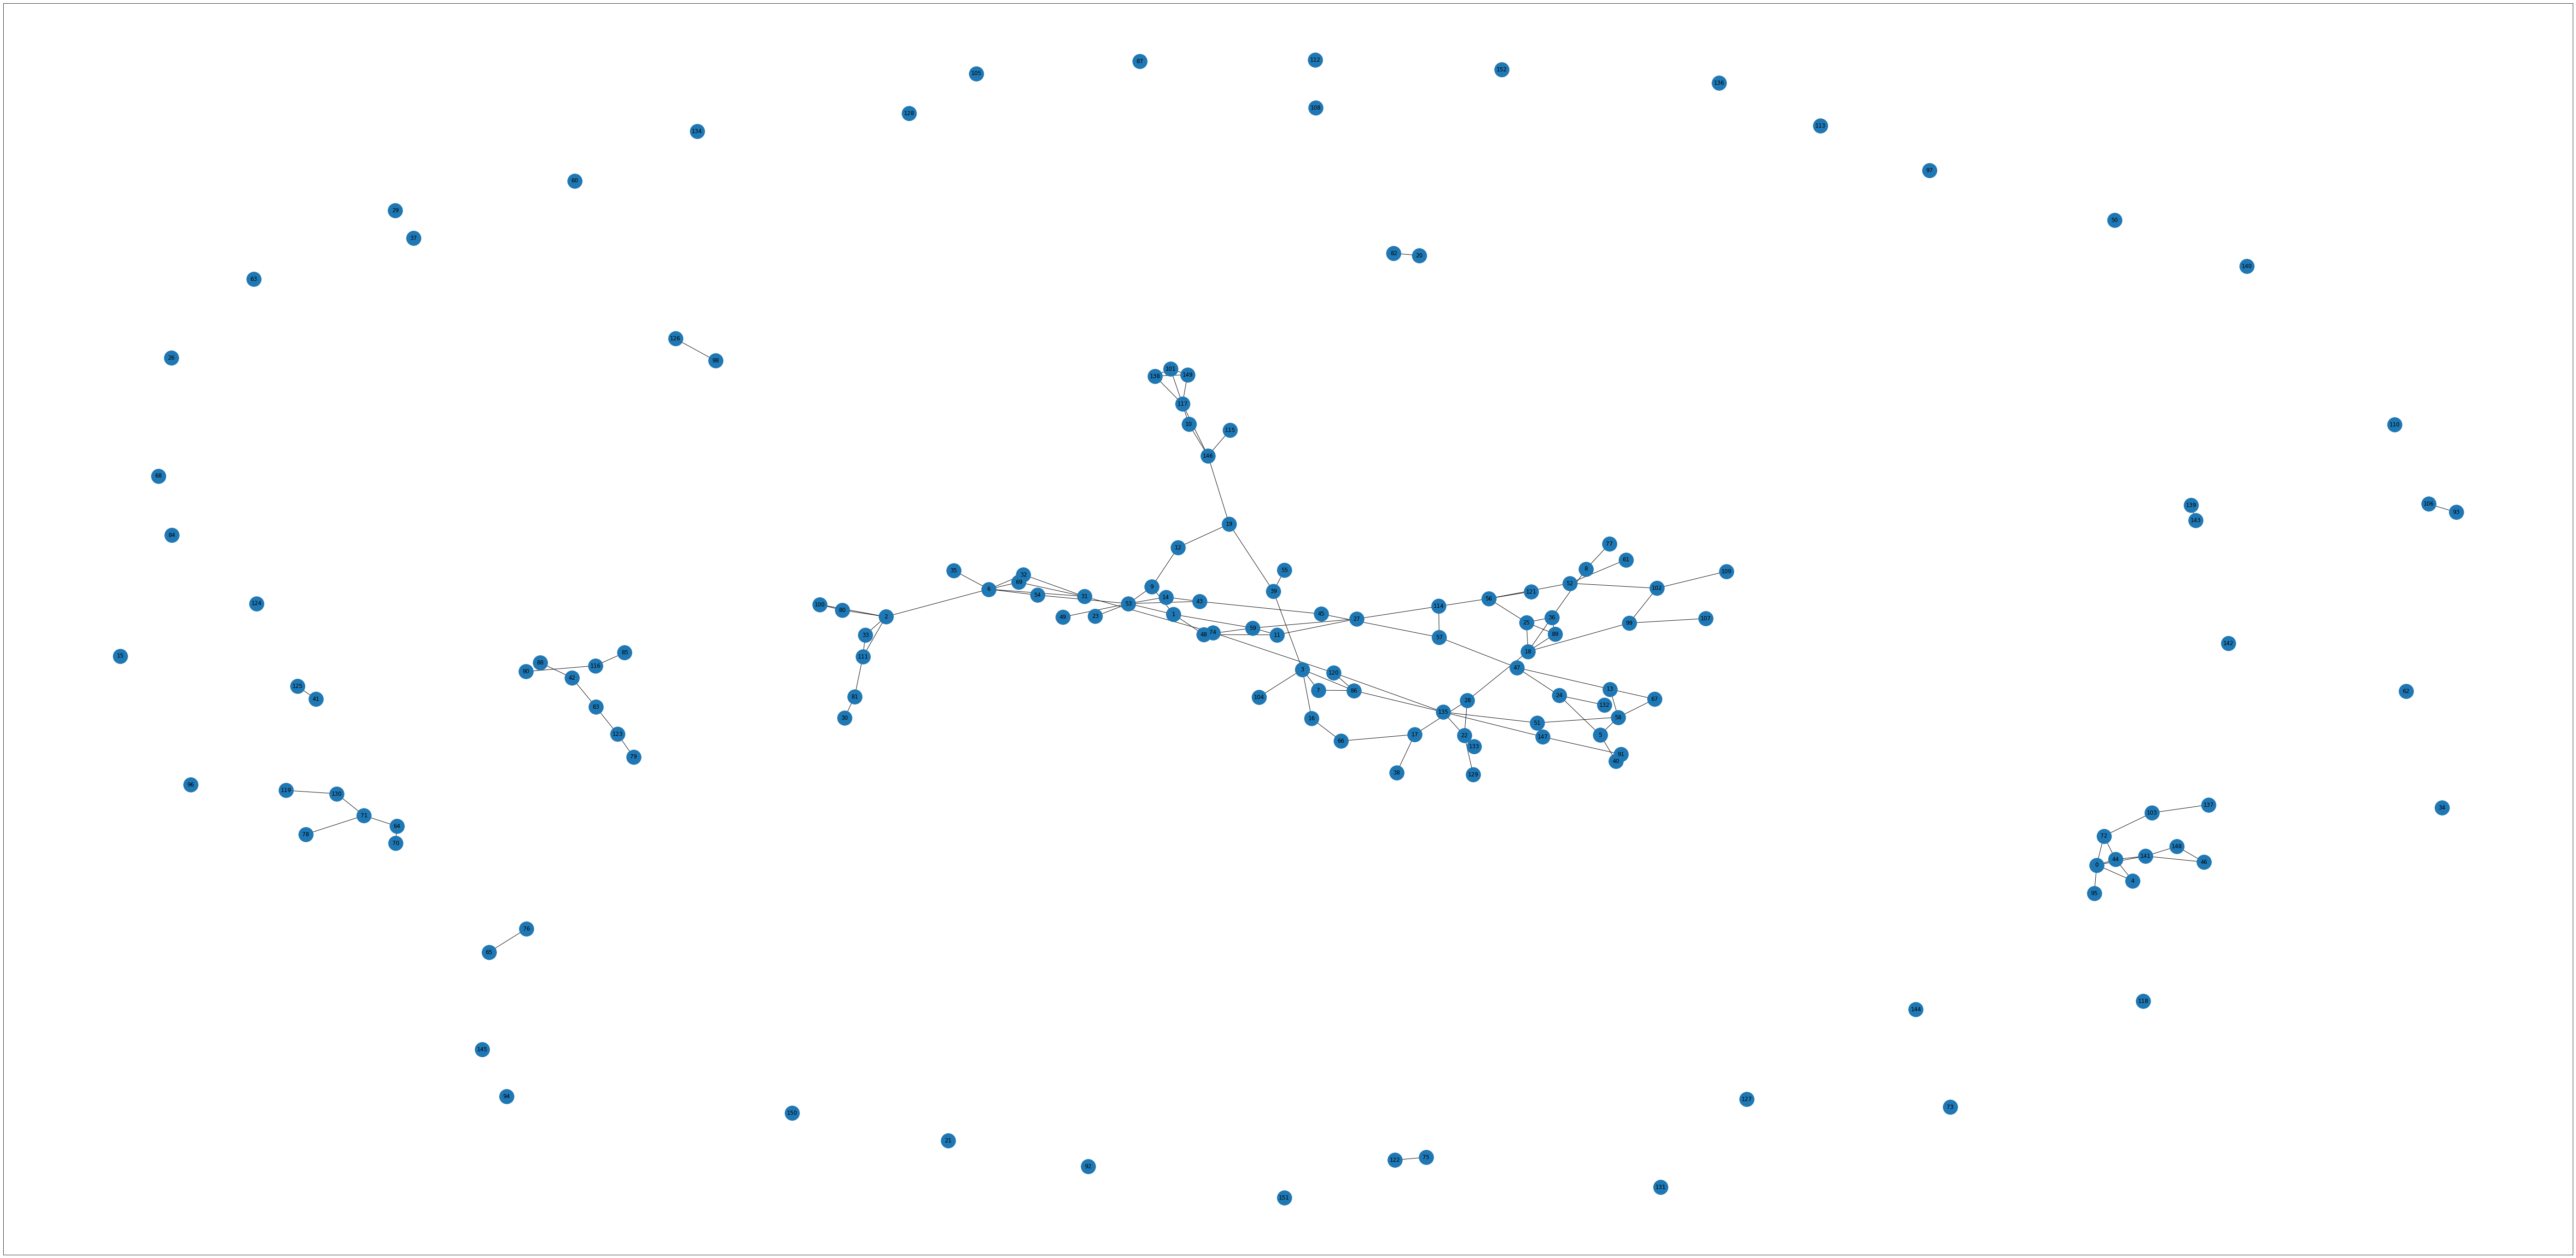

Connected Graph for all in igt_vpp
--------------------


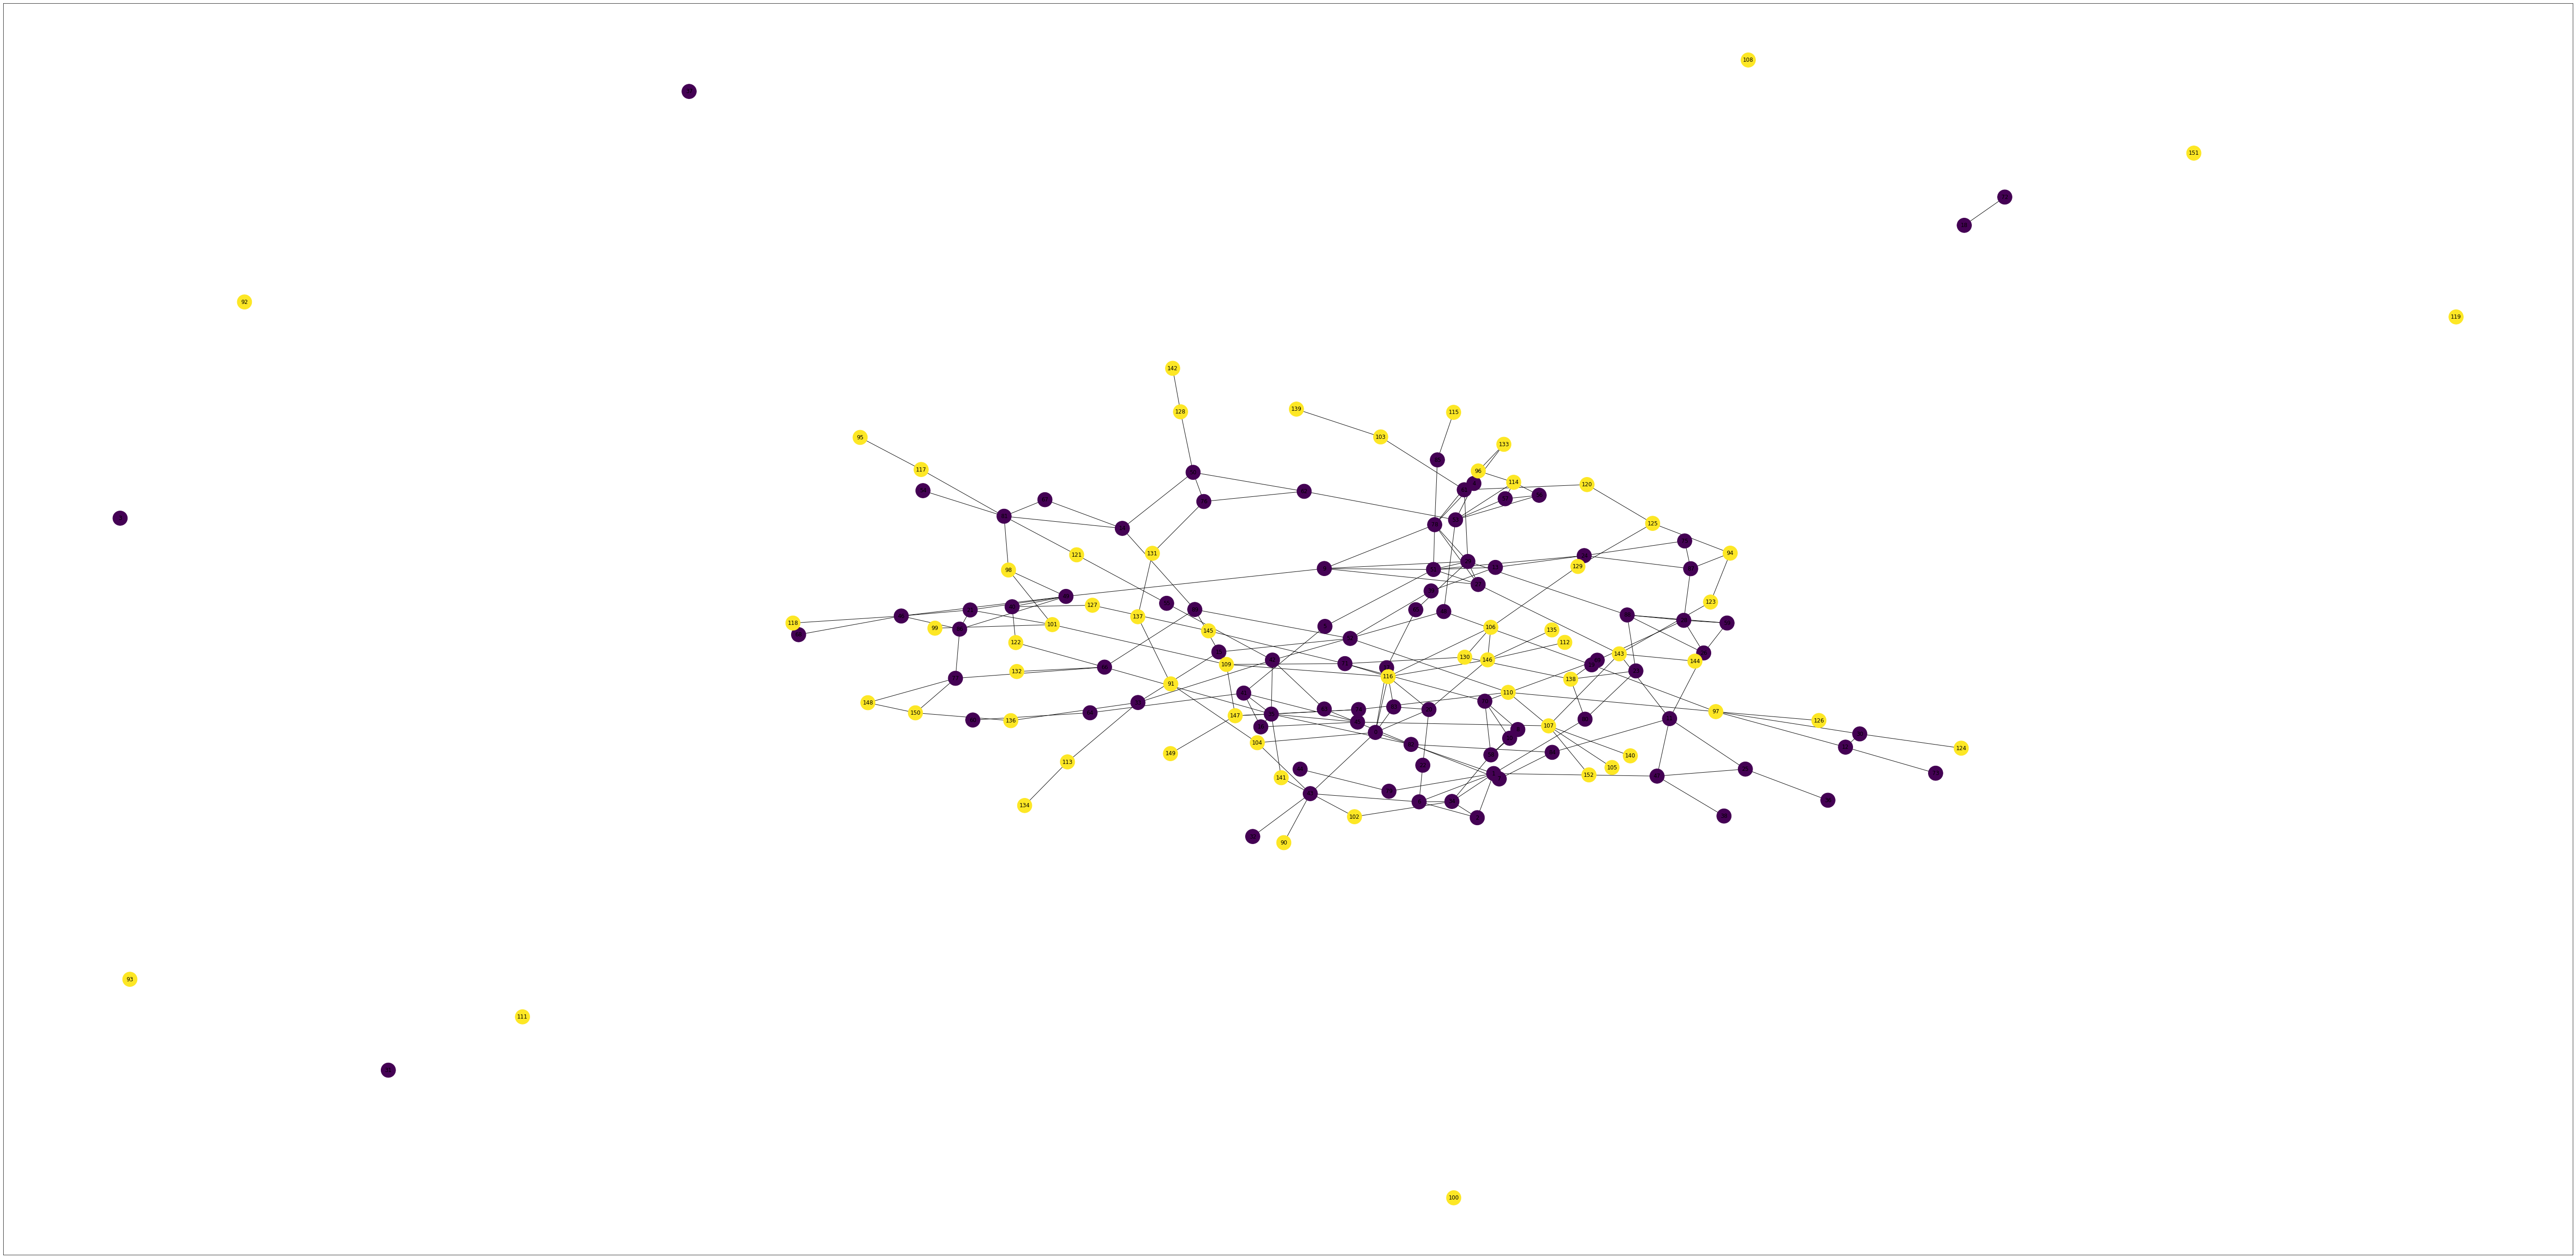

Connected Graph for young in igt_vpp
--------------------


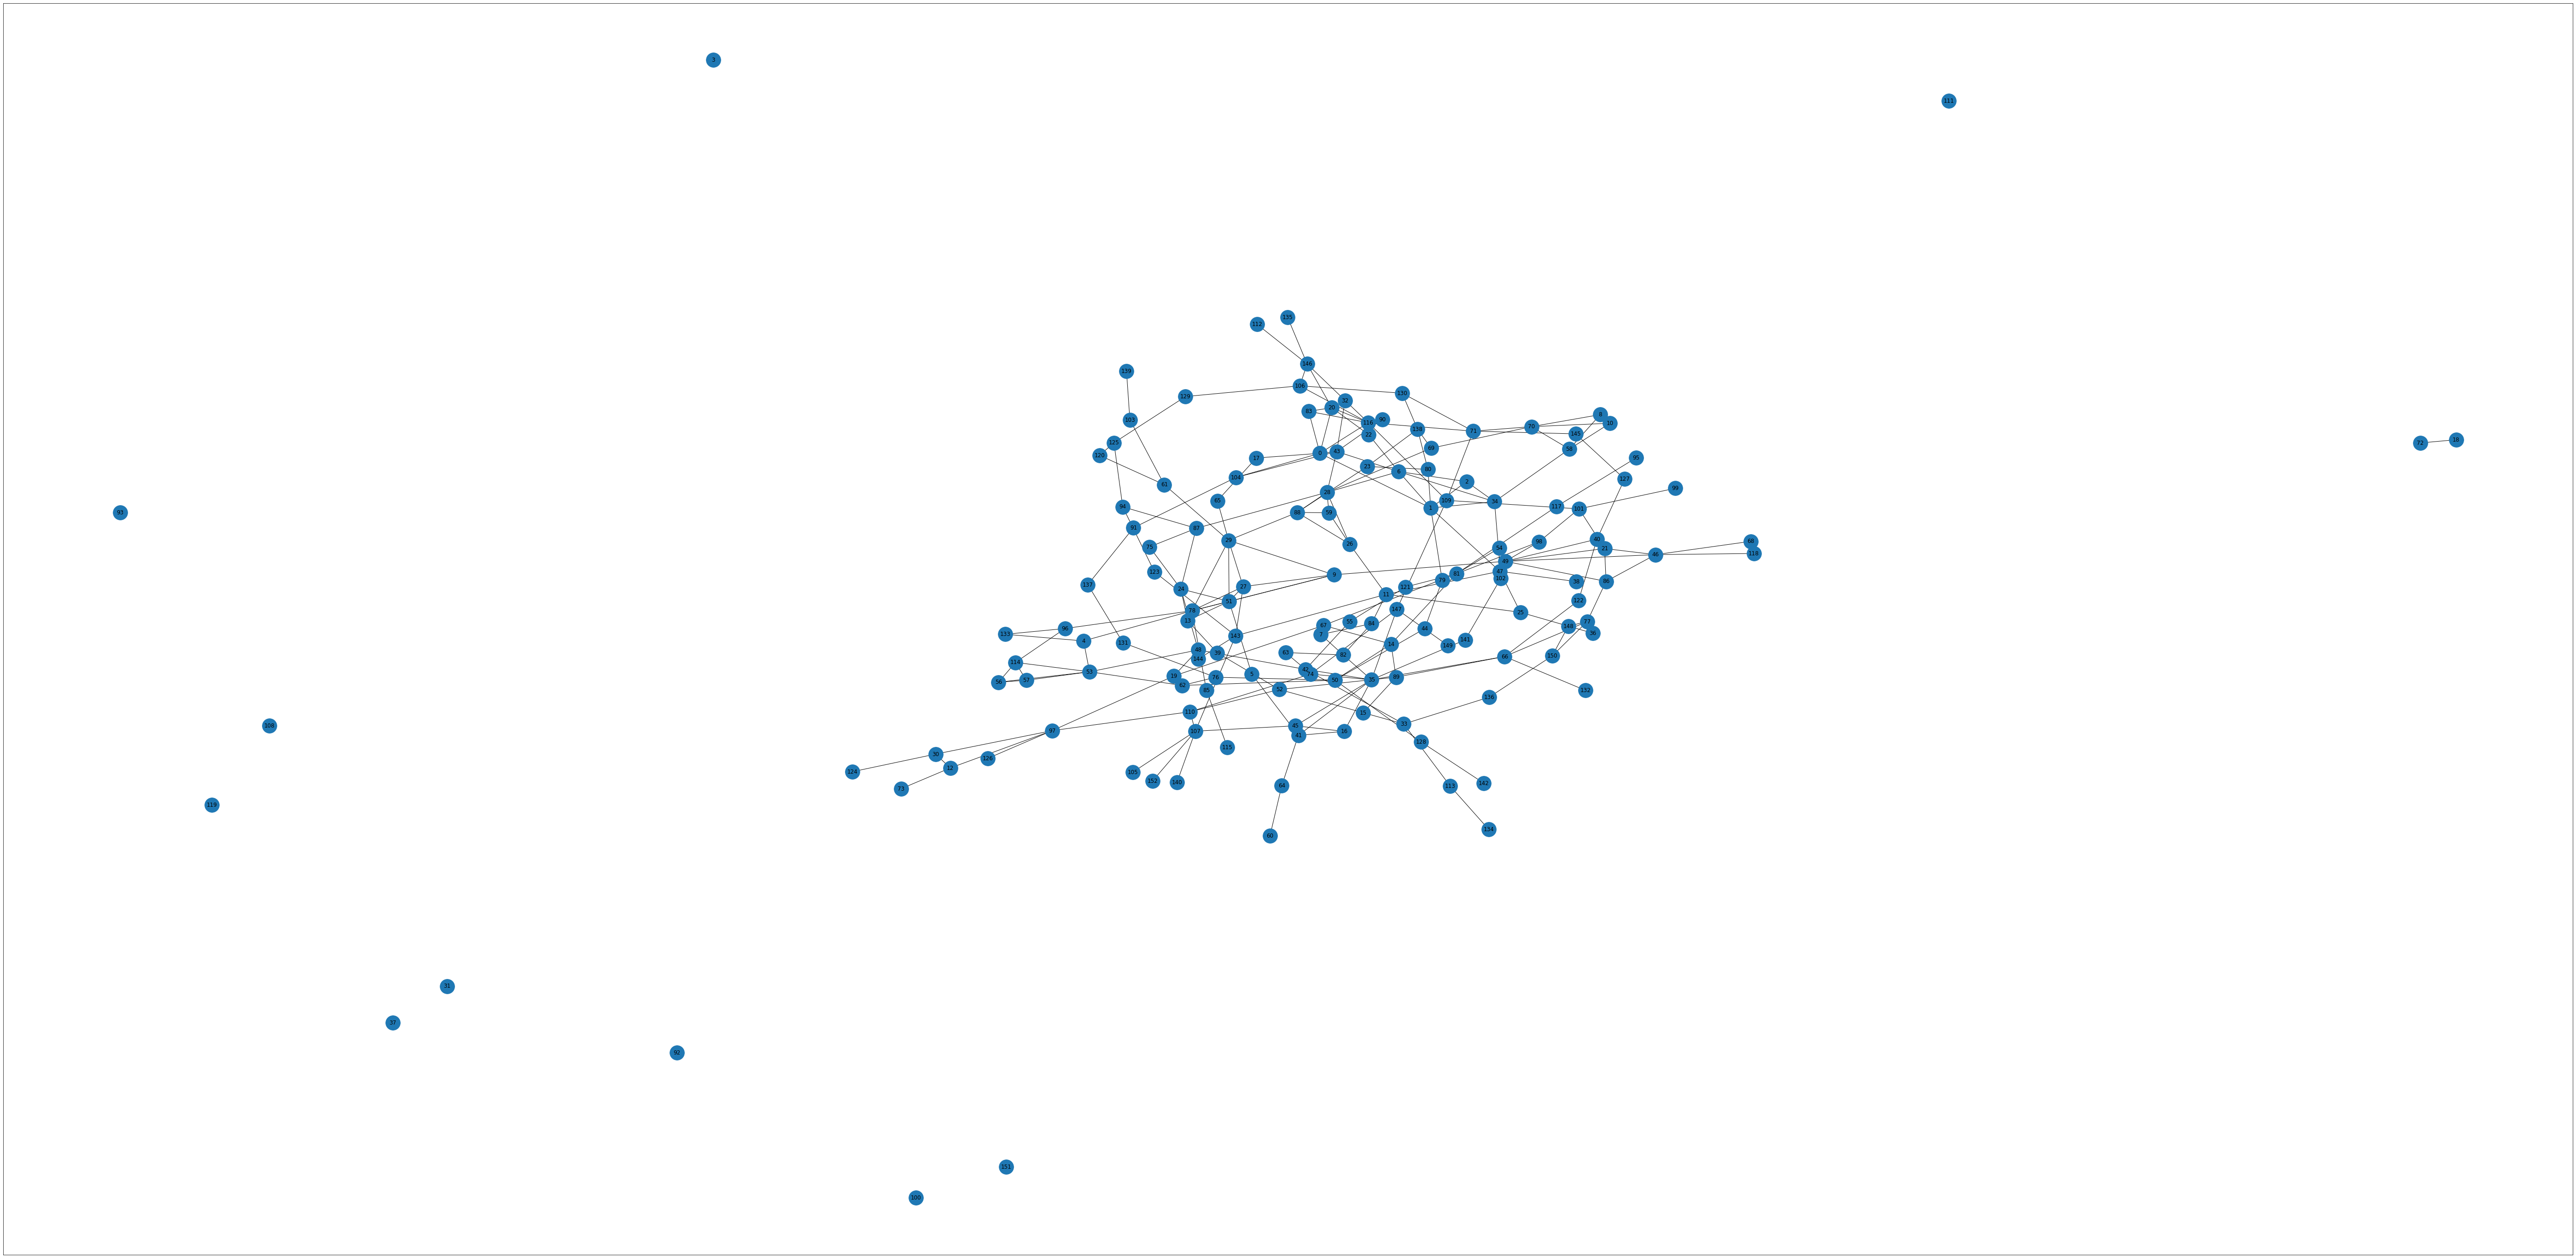

Connected Graph for old in igt_vpp
--------------------


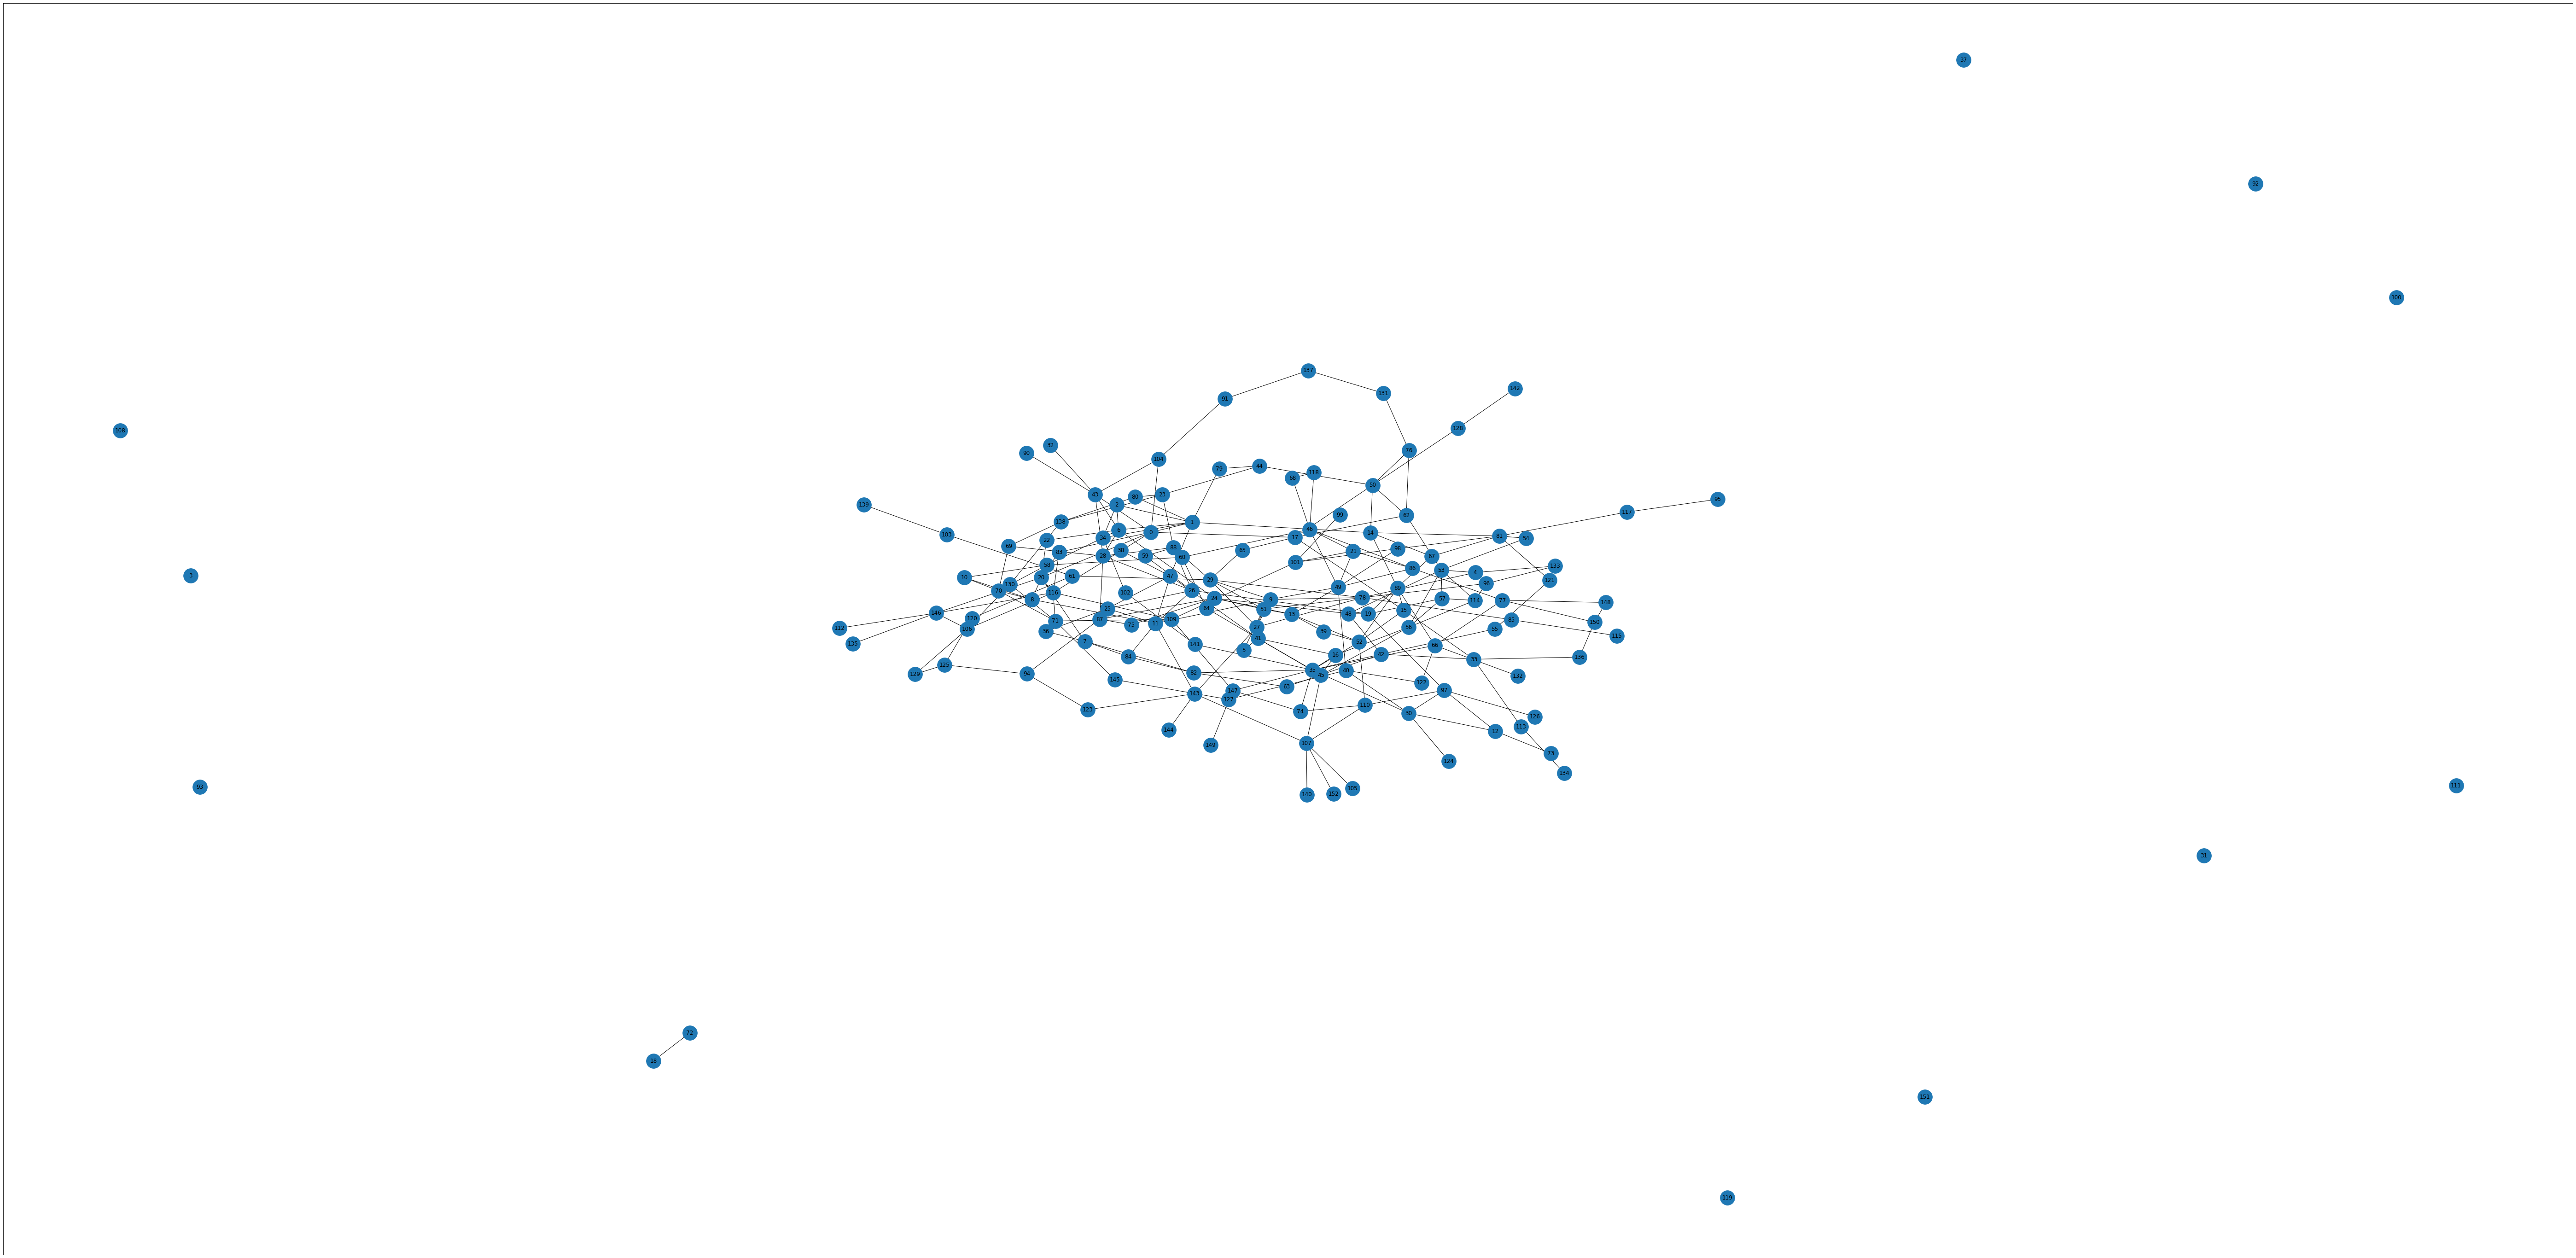

In [7]:
for dataset_name in data['raw_data']:
    for age_group in age_groups:
        print(f"Connected Graph for {age_group} in {dataset_name}")
        print('--------------------')
        plt.figure(figsize=(100,50))
        B = nx.convert_matrix.from_numpy_array(data['processed_data'][dataset_name][age_group]['matrices']['interval_groups']['master'])
        if age_group == 'all':
            nx.draw_networkx(B, with_labels=True, node_color=labels, node_size=1000, font_color='black')
        else:
            nx.draw_networkx(B, with_labels=True, node_size=1000, font_color='black')
        plt.show()

 Based on the graphs above, you can edit the cell below to apply KMeans clustering to any of the adjacency matrices that have been created in the notebook  

Read the comments in the code to see how we select eigenvalues and k.

In [8]:
target_dataset = 'igt_orl'
target_age_group = 'young'
target_matrix = data['processed_data'][target_dataset][target_age_group]['matrices']['interval_groups']['master']

<ipython-input-9-75a5da891081>:31: RuntimeWarning: divide by zero encountered in double_scalars
  r = vals[i] / vals[i-1]


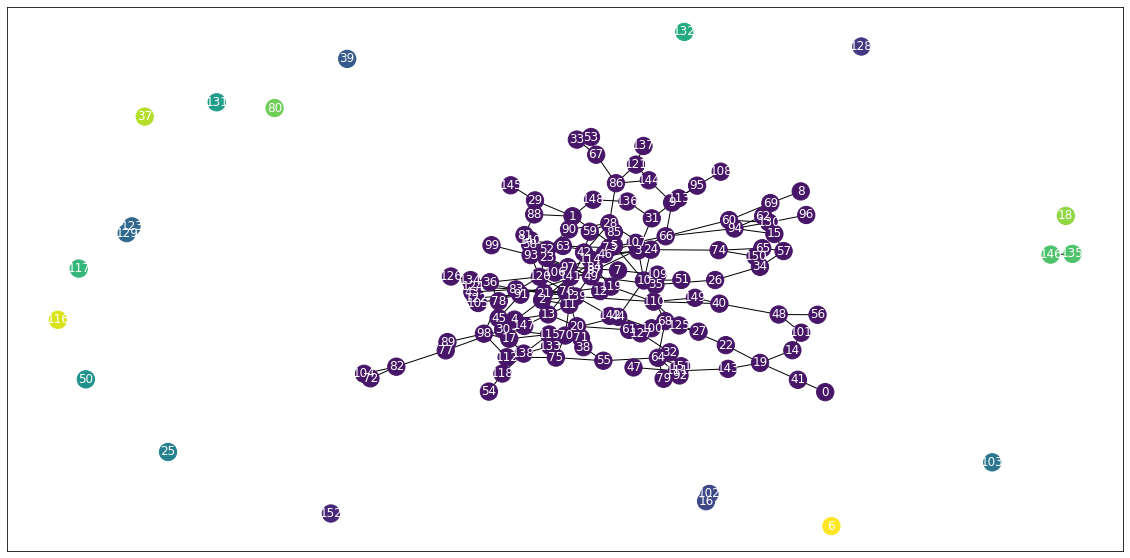

In [9]:
matrix = target_matrix
n = len(matrix)
I = np.identity(n)
A = np.array(matrix)
d = np.sum(A, axis=1)
D = np.diag(d)
L = D - A # graph laplacian

NL= I * d - A
osd=np.zeros(len(d))
for i in range(len(d)):
    if d[i] > 0: osd[i] = np.sqrt(1.0 / d[i])
T = I * osd
NL= np.dot(T,np.dot(NL, T))
# L = NL # uncomment this line to use a normalised lapalacian matrix instead
vals, vecs = np.linalg.eigh(L)

# to find the number of connected components, we have to count the number of eigenvalues = 0
# unfortunately, as numpy is so accurate, we are unable to just count the number of these values that are equal to zero
# to overcome this, we look at the ratio between eigenvalues. if the ratio between two consecutive eigenvalues
# is biggest, this indicates to us that we have found where the eigenvalues become "non-zero".

#Eigenvalue Analysis. 
y = [i for i in range(len(vals))]
z = [i for i in range(len(vals) - 1)]

#build list of ratios
ratio = []
i = 1
while i < len(vals):
    r = vals[i] / vals[i-1]
    ratio.append(abs(r))
    i += 1

#division by zero occurs as there is 1 eigenvalue which is truly 0
#turn infinite values to zero - this needs to be done in order to find the biggest jump
ratio = np.array(ratio)
ratiolist = ratio.tolist()
for n, i in enumerate(ratiolist):
    if i == math.inf:
        ratiolist[n] = 0

#find where there is a massive jump in eigenvalue ratios - this is where they begin to be non zero
zeros = ratiolist.index(max(ratiolist)) + 1

#round the list of ratios to make 1's easier to find
ls = []
for r in ratiolist:
    ls.append(np.round(r, 10))

kmeans = KMeans(n_clusters=zeros)
kmeans.fit(vecs[:,:zeros])
output = kmeans.labels_        
        
plt.figure(figsize=(20,10))
B = nx.convert_matrix.from_numpy_array(matrix)
nx.draw_networkx(B, with_labels=True, node_color=output, font_color='w', vmin=-1)
plt.show()

Here we can see a core group of individuals who behave similarly.  
There are a small number of outliers which are around the outside of the network  

Further analysis could involve breaking down this central component into smaller clusters.